In this project, I explored Reduced Ordered Binary Decision Diagrams (ROBDDs), a powerful data structure for  efficient representation and manipulation of Boolean functions. I developed my own heuristic algorithm to optimize the variable ordering for a given Boolean function. 

Introduction: I was interested in learning about this topic because BDDs are one of the most fundamental data structures and Randal Bryant's 1986 paper on ROBDDs is even today one of the most cited computer science papers. A large number of problems in computer science can be formulated in terms of Boolean functions. Finding a compact representation for Boolean functions where basic Boolean operations like AND and OR and equivalance checking can be performed efficiently is important. There are several ways to represent and manipulate Boolean functions. The classical representation of Boolean functions such as truth tables has a representation of size 2^n or more so it is exponential and therefore too large to be practical. Other methods for representing Boolean functions which are compact (such as Boolean expressions, sum-of-products) are not canonical so checking whether a given Booleam function is satisfiable or if two functions are equivalent can take exponential time in the size of the representation. Also, often simple operations such as NOT can “blow up” the size of the representation. ROBDDs, on the other hand, can perform all Boolean operations in the size of of the graph O(|G|) or O(|G||H|) where G and H are the underlying ROBDD graphs for the function. Further, the ROBDDs are canonical and satisfiability and equivalence can be checked in constant time.

This is why ROBDDs have become the Boolean representation of choice as they are both canoncial and efficiently manipulable. BDDs work by repeatedly using Shannon Decomposition of a Boolean function. There are two main restrictions that are used: sharing all common subgraphs , and ordering variables so that the variables appear in a fixed path from root to the leaf on every path, that makes ROBDD compact, canonical and efficient to manipulate.

Challenges of ROBDDs: Even though ROBDDs can be polynomial in many practical cases, there are instances where ROBDD representation also becomes exponential in the number of variables. There are many functions, such as binary multiplication, where it has been shown that the ROBDD representation is exponential for any variable ordering. For many other functions, the ROBDD size is very sensitive to the variable ordering, and the size of a ROBDD can vary exponentially between a good and a bad order.  Therefore, there is a need to find a variable order to minimize the number of nodes in an ROBDD. Unfortunately, determining the best variable order for a given Boolean function is NP-hard. So typically heuristics are developed to find a good variable order.

My project consists of implementing a simple heuristic algorithm from scratch that gives a good variable order for a given Boolean expression. 

Implementation Details: The heuristic orders the variable that is mostly frequently used across the clauses of a function. The reasoning for this is if you resolve the variable at the top of the tree then you have to have fewer repetition of this variable in the ROBDD diagram. To do this, I first convert the given Boolean function in Disjunctive Normal Form (DNF). A benefit of converting to a DNF format is that you can analyze each clause in a function seperately. I am then able to calculate the frequency of Boolean variables in a given function and sort the variables based on the frequency of variables in descending order. For each of these sorted variables, I then pick variables that co-occur within the same clause (AND operator) and return the best variable ordering.  

Analysis: I then implement a function to compare the number of ROBDD nodes from the optimal variable ordering found by my heuristic algorithm against a random set of variable orders I generate. I report the minimum, median, and maximum number of nodes from the set of randomly generated variable orders as well as the nodes from my heuristic solution. For some Boolean functions, my heuristic algorithm outperforms or performs as well as the minimum and median variable orders that were randomly generated and for other Boolean functions it has the same number of nodes as the worst case. 

Visualizations: Finally, I use an open-source package called Graphviz to represent the impact of different variable orderings as a graph.

In [1]:
%install_ext https://raw.github.com/cjdrake/ipython-magic/master/gvmagic.py

UsageError: Line magic function `%install_ext` not found.


In [2]:
%load_ext gvmagic

In [10]:
# PyEDA library is used for Boolean expression and ROBDD creation

import pyeda
import numpy
import random
import statistics

from pyeda.inter import *
from pyeda.boolalg.bdd import _NODES
from pygraphviz import AGraph

In [11]:
# Calculate number nodes for an ROBDD given Boolean function and variable order 

def order_variable_stats(func, order, printBool):
    X = bddvars('x', len(order))
    Y = bddvars('y', len(order))
    
    # Create ROBDD from Boolean expression without specifying variable order
    func_bdd = expr2bdd(func)
    
    # Recreate ROBDD using the desired variable order 
    func_new = func_bdd.compose({X[0]: Y[order[0]], X[1]: Y[order[1]], 
                             X[2]: Y[order[2]], X[3]: Y[order[3]], 
                             X[4]: Y[order[4]], X[5]: Y[order[5]]})
    
    # Convert ROBDD to Graphviz Acyclic Graph repersentation in order to iterate over the tree structure
    graph = AGraph(func_new.to_dot())
    num_edges = len(list(graph.iteredges()))
    num_nodes = len(list(graph.iternodes()))
    if (num_nodes < 10 & printBool == True):
        print("Number of Nodes: ", num_nodes, " ::: ", order)
    if (num_nodes >= 10 & printBool == True):
        print("Number of Nodes:", num_nodes, " ::: ", order)
    return (num_nodes)

In [12]:
# Find the optimized variable order 

def heuristic_var_order(func, orgVarOrder):
    func_expr = func
    
    # Convert Boolean function to DNF (Disjunctive Normal Form) format
    func_dnf = func_expr.to_dnf()
    func_dnf_str = str(func_dnf)
    
    # Calculate the frequency of Boolean variables 
    freq_var = []
    for var in orgVarOrder:
        varTmp = "[%d]" % var
        freq_var.append(func_dnf_str.count(varTmp))
    
    # Sort Boolean variables in descending order based on the frequency
    freq_var_idx = numpy.argsort(freq_var)
    freq_var_idx = freq_var_idx[::-1]
    
    '''
    Identify the order of variables by:
    (a) iterate over the sorted variables
    (b) for each variable in (a), pick variables that co-occur within the same clause
    '''
    clauses = func_dnf_str.split('And')
    clauses = clauses[1:len(clauses)]
    bestVarOrder = []
    for index in freq_var_idx:
        if index not in bestVarOrder:
            bestVarOrder.append(int(index))
            varTmp = "[%d]" % index

            for clause in clauses:
                if varTmp in clause:
                    vars = clause.split(',')
                    for var in vars:
                        varClean = var.replace('(','')
                        varClean = varClean.replace(')','')
                        varClean = varClean.replace(',','')
                        varClean = varClean.replace(' ','')
                        varClean = varClean.replace('~','')
                        varClean = varClean.replace('x[','')
                        varClean = varClean.replace(']','')
                        if varClean != '':
                            varClean = int(varClean)
                            if varClean not in bestVarOrder:
                                bestVarOrder.append(varClean)
    return(bestVarOrder)

In [13]:
'''
Analyze results from the heuristic solution for a given Boolean function:
-- Generate random order of variables and report{min, medium, and max} number of nodes in the ROBDD
-- Calculate variable order the heuristic solution and report number of nodes in resulting ROBDD
'''

def analyze_heuristic_algorithm(bool_func, orgVarOrder, printBool):
    print ('\nBoolean function to analyze')
    print(bool_func)

    # Generate random order of variables and calculate number of BDD nodes
    print ('Performing Random variable ordering analysis')
    random_results = []
    for i in range(20):
        randOrder = orgVarOrder[:]
        random.shuffle(randOrder)
        num_nodes = order_variable_stats(bool_func,randOrder, printBool)
        random_results.append(num_nodes)
    print('Min: ', min(random_results), ' ::: Median:', statistics.median(random_results), ' ::: Max:', max(random_results))

    # Find best order of variables based on heuristic algorithm and calculate number of BDD nodes
    print ('Performing Heuristics optimization')
    bestVarOrder = heuristic_var_order(bool_func, orgVarOrder)
    num_nodes = order_variable_stats(bool_func,bestVarOrder,printBool)
    print('Heuristic: ',num_nodes)

In [7]:
# Main script to apply and analyze heuristic algorithm on various Booolean functions

X = exprvars('x', 8)
orgVarOrder = [0,1,2,3,4,5]
printBool = False

bool_func = Or(And(X[0],X[1]), And(Not(X[0]),X[2]), And(X[3],X[4]), And(Not(X[3]),X[5]))
analyze_heuristic_algorithm(bool_func,orgVarOrder,printBool)

bool_func = Or(And(X[0],X[1]), And(X[2],X[3]), And(X[4],X[5]))
analyze_heuristic_algorithm(bool_func,orgVarOrder,printBool)

bool_func = And(Or(X[0], X[1]), Or(X[2], X[3]), Or(X[4], X[5]))
analyze_heuristic_algorithm(bool_func,orgVarOrder,printBool)

bool_func = Or(And(X[1],Not(X[2])), And(Not(X[0]),X[3]), And(X[2],X[5]),And(Not(X[1]),X[3]))
analyze_heuristic_algorithm(bool_func,orgVarOrder,printBool)


bool_func = Or(And(Not(X[1]),Not(X[3])), And(Not(X[2]),X[3]), And(X[3],X[5]),And(Not(X[4]),X[0]))
analyze_heuristic_algorithm(bool_func,orgVarOrder,printBool)



Boolean function to analyze
Or(And(x[0], x[1]), And(~x[0], x[2]), And(x[3], x[4]), And(~x[3], x[5]))
Performing Random variable ordering analysis
Min:  8  ::: Median: 14.5  ::: Max: 23
Performing Heuristics optimization
Heuristic:  8

Boolean function to analyze
Or(And(x[0], x[1]), And(x[2], x[3]), And(x[4], x[5]))
Performing Random variable ordering analysis
Min:  8  ::: Median: 14.0  ::: Max: 16
Performing Heuristics optimization
Heuristic:  8

Boolean function to analyze
And(Or(x[0], x[1]), Or(x[2], x[3]), Or(x[4], x[5]))
Performing Random variable ordering analysis
Min:  8  ::: Median: 10.0  ::: Max: 16
Performing Heuristics optimization
Heuristic:  16

Boolean function to analyze
Or(And(x[1], ~x[2]), And(~x[0], x[3]), And(x[2], x[5]), And(~x[1], x[3]))
Performing Random variable ordering analysis
Min:  9  ::: Median: 10.0  ::: Max: 12
Performing Heuristics optimization
Heuristic:  10

Boolean function to analyze
Or(And(~x[1], ~x[3]), And(~x[2], x[3]), And(x[3], x[5]), And(x[0], ~

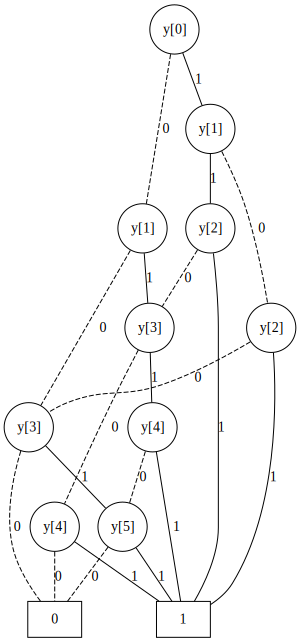

In [8]:
# Non-optimized variable ordering

X = bddvars('x', 8)
Y = bddvars('y', 8)

f1 = X[0] & X[1] | X[2] & X[3] | X[4] & X[5]
f2 = f1.compose({X[0]: Y[0], X[1]: Y[2], 
                             X[2]: Y[4], X[3]: Y[1], 
                             X[4]: Y[3], X[5]: Y[5]})
%dotobj f2

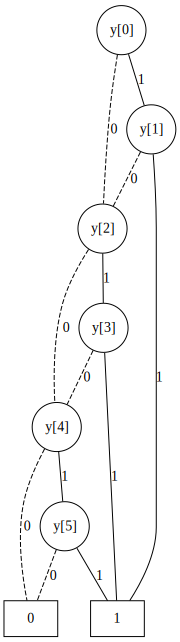

In [9]:
# Optimized variable ordering from the heuristic algorithm on same Boolean function 

X = bddvars('x', 8)
Y = bddvars('y', 8)

f1 = X[0] & X[1] | X[2] & X[3] | X[4] & X[5]
f2 = f1.compose({X[0]: Y[0], X[1]: Y[1], 
                             X[2]: Y[2], X[3]: Y[3], 
                             X[4]: Y[4], X[5]: Y[5]})

%dotobj f2